# Compare docking strategies

This notebook explores and visualizes the performance of the docking algorithms **Fred**, **Hybrid** and **Posit**. Additionally, a Posit experiment is included, in which the most similar co-crystallized ligand from all available kinase structures in the same conformation is transferred to bias the docking algorithm.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)
posit_template_results = pd.read_csv("../data/posit_template_results.csv", index_col=0)

## Average performance

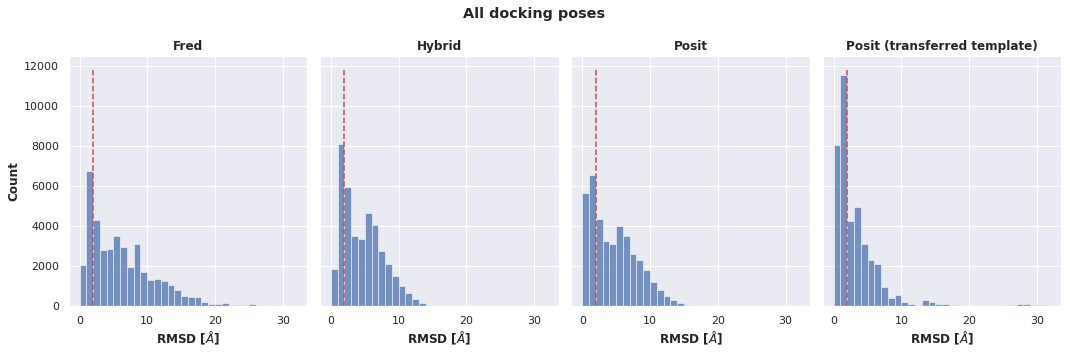

In [5]:
def plot_average_performance(fred_results, hybrid_results, posit_results, posit_template_results):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 3 subplots
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 5))
    
    # plot data
    bins = range(
        0, 
        int(max(
            fred_results["rmsd"].max(), 
            hybrid_results["rmsd"].max(), 
            posit_results["rmsd"].max(),
            posit_template_results["rmsd"].max()
        )), 
        1
    )
    sns.histplot(data=fred_results, x="rmsd", bins=bins, ax=axes[0])
    sns.histplot(data=hybrid_results, x="rmsd", bins=bins, ax=axes[1])
    sns.histplot(data=posit_results, x="rmsd", bins=bins, ax=axes[2])
    sns.histplot(data=posit_template_results, x="rmsd", bins=bins, ax=axes[3])
    
    # titles
    fig.suptitle("All docking poses", fontweight="bold")
    axes[0].set_title("Fred", fontweight="bold")
    axes[1].set_title("Hybrid", fontweight="bold")
    axes[2].set_title("Posit", fontweight="bold")
    axes[3].set_title("Posit (transferred template)", fontweight="bold")
    
    # axes and 2 A cutoff
    axes[0].set_ylabel("Count", fontweight="bold")
    for i in range(4):
        axes[i].set_xlabel("RMSD [$\AA$]", fontweight="bold")
        axes[i].vlines(2, ymin=0, ymax=11900, colors="r", linestyles="dashed")
        
    plt.tight_layout()
    
    return
        

plot_average_performance(fred_results, hybrid_results, posit_results, posit_template_results)

## Best performance per system

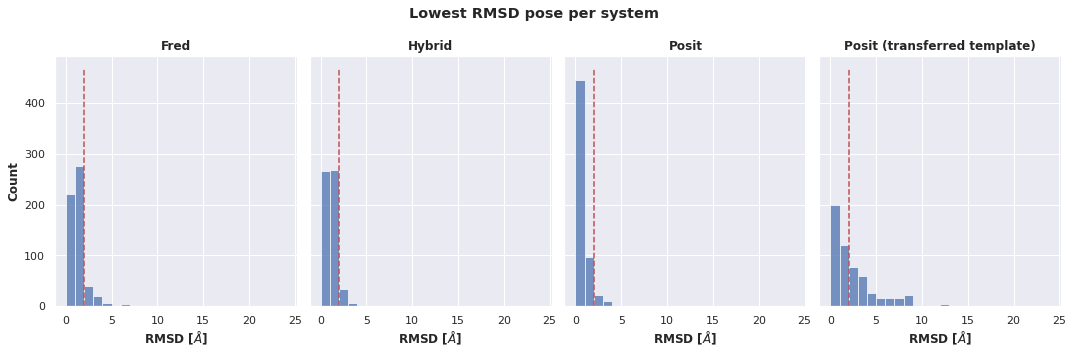

In [6]:
def plot_best_performance(fred_results, hybrid_results, posit_results, posit_template_results):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]    
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # sort by rmsd and pick the lowest RMSD pose per system
    fred_results = fred_results.sort_values("rmsd")
    fred_results = fred_results.groupby(["ligand_pdb_id"]).head(1)
    hybrid_results = hybrid_results.sort_values("rmsd")
    hybrid_results = hybrid_results.groupby(["ligand_pdb_id"]).head(1)
    posit_results = posit_results.sort_values("rmsd")
    posit_results = posit_results.groupby(["ligand_pdb_id"]).head(1)
    posit_template_results = posit_template_results.sort_values("rmsd")
    posit_template_results = posit_template_results.groupby(["ligand_pdb_id"]).head(1)
    
    # 3 subplots
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 5))
    
    # plot data
    bins = range(
        0, 
        int(max(
            fred_results["rmsd"].max(), 
            hybrid_results["rmsd"].max(), 
            posit_results["rmsd"].max(),
            posit_template_results["rmsd"].max()
        )), 
        1
    )
    sns.histplot(data=fred_results, x="rmsd", bins=bins, ax=axes[0])
    sns.histplot(data=hybrid_results, x="rmsd", bins=bins, ax=axes[1])
    sns.histplot(data=posit_results, x="rmsd", bins=bins, ax=axes[2])
    sns.histplot(data=posit_template_results, x="rmsd", bins=bins, ax=axes[3])
    
    # titles
    fig.suptitle("Lowest RMSD pose per system", fontweight="bold")
    axes[0].set_title("Fred", fontweight="bold")
    axes[1].set_title("Hybrid", fontweight="bold")
    axes[2].set_title("Posit", fontweight="bold")
    axes[3].set_title("Posit (transferred template)", fontweight="bold")
    
    # axes and 2 A cutoff
    axes[0].set_ylabel("Count", fontweight="bold")
    for i in range(4):
        axes[i].set_xlabel("RMSD [$\AA$]", fontweight="bold")
        axes[i].vlines(2, ymin=0, ymax=470, colors="r", linestyles="dashed")
    
    plt.tight_layout()
    
    return
    
    
plot_best_performance(fred_results, hybrid_results, posit_results, posit_template_results)

## Both together including bootstrapping wo Posit (transferred template)

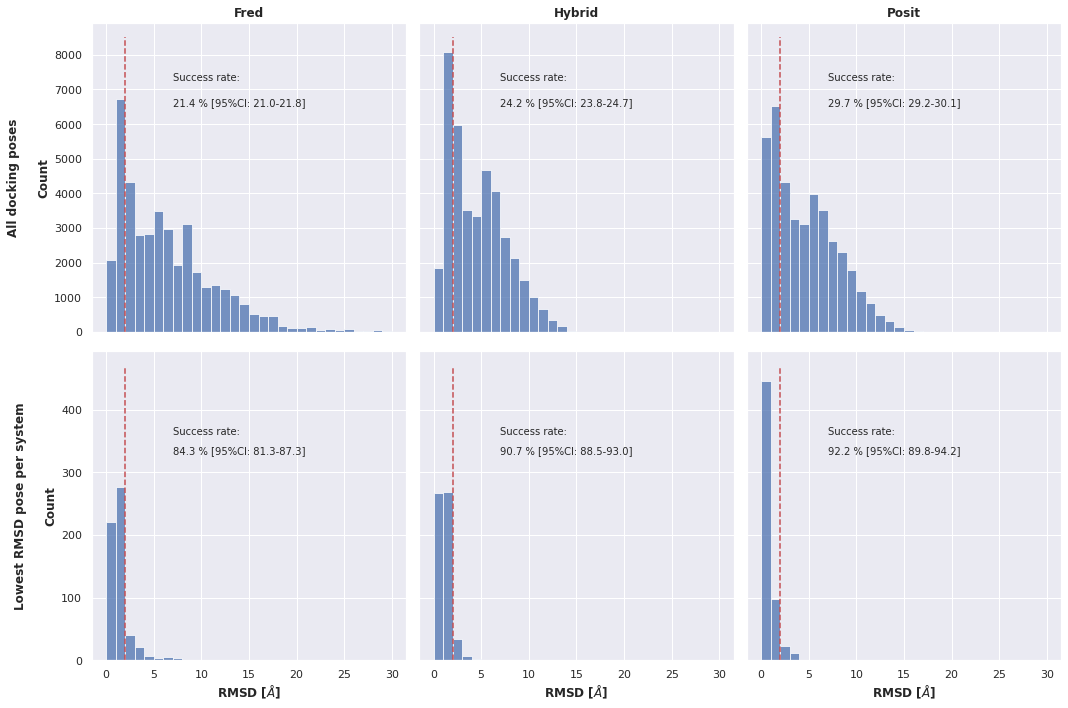

In [7]:
def plot_performance(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]    
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 6 subplots
    fig, axes = plt.subplots(2, 3, sharey='row', sharex=True, figsize=(15, 10))
    
    # plot data
    bins = range(
        0, 
        int(max(
            fred_results["rmsd"].max(), 
            hybrid_results["rmsd"].max(), 
            posit_results["rmsd"].max(),
        )), 
        1
    )
    sns.histplot(data=fred_results, x="rmsd", bins=bins, ax=axes[0][0])
    sns.histplot(data=hybrid_results, x="rmsd", bins=bins, ax=axes[0][1])
    sns.histplot(data=posit_results, x="rmsd", bins=bins, ax=axes[0][2])
    
    # titles
    axes[0][0].set_title("Fred", fontweight="bold")
    axes[0][1].set_title("Hybrid", fontweight="bold")
    axes[0][2].set_title("Posit", fontweight="bold")
    
    # axes and 2 A cutoff
    axes[0][0].set_ylabel("All docking poses\n\nCount", fontweight="bold")
    for i in range(3):
        axes[0][i].set_xlabel("")
        axes[0][i].vlines(2, ymin=0, ymax=8500, colors="r", linestyles="dashed")
    
    # sort by rmsd and pick the lowest RMSD pose per system
    fred_results_best = fred_results.sort_values("rmsd")
    fred_results_best = fred_results_best.groupby(["ligand_pdb_id"]).head(1)
    hybrid_results_best = hybrid_results.sort_values("rmsd")
    hybrid_results_best = hybrid_results_best.groupby(["ligand_pdb_id"]).head(1)
    posit_results_best = posit_results.sort_values("rmsd")
    posit_results_best = posit_results_best.groupby(["ligand_pdb_id"]).head(1)
    
    # plot data
    sns.histplot(data=fred_results_best, x="rmsd", bins=bins, ax=axes[1][0])
    sns.histplot(data=hybrid_results_best, x="rmsd", bins=bins, ax=axes[1][1])
    sns.histplot(data=posit_results_best, x="rmsd", bins=bins, ax=axes[1][2])
    
    # axes and 2 A cutoff
    axes[1][0].set_ylabel("Lowest RMSD pose per system\n\nCount", fontweight="bold")
    for i in range(3):
        axes[1][i].set_xlabel("RMSD [$\AA$]", fontweight="bold")
        axes[1][i].vlines(2, ymin=0, ymax=470, colors="r", linestyles="dashed")
    
    # bootstrapping for confidence intervals
    sampled_success_rates = []
    for i, (method, results) in enumerate(zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results])):
        for j, focus in enumerate(["All docking poses", "Lowest RMSD pose per system"]):
            sampled_success_rates_i = []
            if focus == "All docking poses":
                success_labels = (results["rmsd"] <= 2).to_list()
            elif focus == "Lowest RMSD pose per system":
                selected_results = results.sort_values("rmsd")
                selected_results = selected_results.groupby(["ligand_pdb_id"]).head(1)
                success_labels = (selected_results["rmsd"] <= 2).to_list()
            for _ in range(n_bootstrap):
                sampled_success_labels = resample(success_labels)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([
                method,
                focus,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])
            ys = [7250, 6525]
            if j == 1:
                ys = [360, 330]
            axes[j][i].annotate(
                "Success rate:", 
                xy=(7, ys[0]),
                fontsize=10,
            )
            axes[j][i].annotate(
                f"{success_rate_mean:.1f} % [95%CI: {ci_lower_bound:.1f}-{ci_upper_bound:.1f}]", 
                xy=(7, ys[1]),
                fontsize=10,
            )
    
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, columns=["method", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
    
    plt.tight_layout()
    plt.savefig(directory / "docking_performance.png", dpi=300)
    
    return sampled_success_rates


sampled_success_rates = plot_performance(fred_results, hybrid_results, posit_results)

In [8]:
sampled_success_rates

,method,focus,success_rate,ci_lower,ci_upper
0,Fred,All docking poses,21.434650,21.030607,21.828621
1,Fred,Lowest RMSD pose per system,84.339898,81.324278,87.266553
2,Hybrid,All docking poses,24.245491,23.822992,24.688529
3,Hybrid,Lowest RMSD pose per system,90.668421,88.455008,93.039049
4,Posit,All docking poses,29.656102,29.249561,30.102887
5,Posit,Lowest RMSD pose per system,92.165705,89.813243,94.227504


## Both together including bootstrapping for Posit (transferred template)

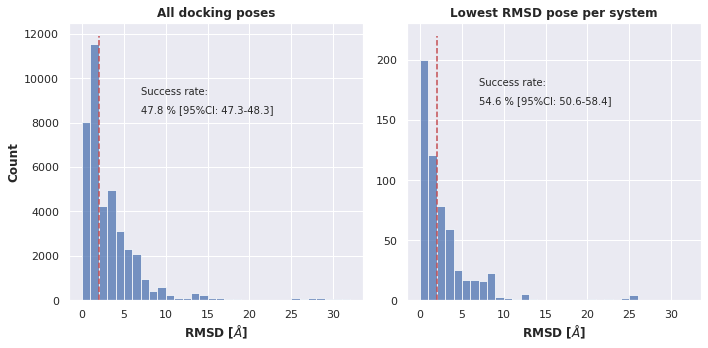

In [9]:
def plot_performance(posit_template_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # plot data
    bins = range(
        0, 
        int(posit_template_results["rmsd"].max()), 
        1
    )
    sns.histplot(data=posit_template_results, x="rmsd", bins=bins, ax=axes[0])
    
    # title
    axes[0].set_title("All docking poses", fontweight="bold")
    
    # axes and 2 A cutoff
    axes[0].set_ylabel("Count", fontweight="bold")
    axes[0].set_xlabel("RMSD [$\AA$]", fontweight="bold")
    axes[0].vlines(2, ymin=0, ymax=11900, colors="r", linestyles="dashed")
    
    # sort by rmsd and pick the lowest RMSD pose per system
    posit_template_results_best = posit_template_results.sort_values("rmsd")
    posit_template_results_best = posit_template_results_best.groupby(["ligand_pdb_id"]).head(1)
    
    # plot data
    sns.histplot(data=posit_template_results_best, x="rmsd", bins=bins, ax=axes[1])
    
    # title
    axes[1].set_title("Lowest RMSD pose per system", fontweight="bold")
    
    # axes and 2 A cutoff
    axes[1].set_ylabel("", fontweight="bold")
    axes[1].set_xlabel("RMSD [$\AA$]", fontweight="bold")
    axes[1].vlines(2, ymin=0, ymax=220, colors="r", linestyles="dashed")
    
    # bootstrapping for confidence intervals
    sampled_success_rates = []
    for i, (method, results) in enumerate(zip(["Posit template"], [posit_template_results])):
        for j, focus in enumerate(["All docking poses", "Lowest RMSD pose per system"]):
            sampled_success_rates_i = []
            if focus == "All docking poses":
                success_labels = (results["rmsd"] <= 2).to_list()
            elif focus == "Lowest RMSD pose per system":
                selected_results = results.sort_values("rmsd")
                selected_results = selected_results.groupby(["ligand_pdb_id"]).head(1)
                success_labels = (selected_results["rmsd"] <= 2).to_list()
            for _ in range(n_bootstrap):
                sampled_success_labels = resample(success_labels)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([
                method,
                focus,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])
            ys = [9250, 8450]
            if j == 1:
                ys = [179, 164]
            axes[j].annotate(
                "Success rate:", 
                xy=(7, ys[0]),
                fontsize=10,
            )
            axes[j].annotate(
                f"{success_rate_mean:.1f} % [95%CI: {ci_lower_bound:.1f}-{ci_upper_bound:.1f}]", 
                xy=(7, ys[1]),
                fontsize=10,
            )
    
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, columns=["method", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
    
    plt.tight_layout()
    plt.savefig(directory / "docking_performance_posit_transferred_template.png", dpi=300)
    
    return sampled_success_rates


sampled_success_rates = plot_performance(posit_template_results)

In [10]:
sampled_success_rates

,method,focus,success_rate,ci_lower,ci_upper
0,Posit template,All docking poses,47.808201,47.291616,48.276705
1,Posit template,Lowest RMSD pose per system,54.588245,50.596252,58.432709
